First of all, As we are running this code using Google Colab's GPU, We are checking the working directory.

In [1]:
import os

os.getcwd()

'/content'

Mounting Google drive into Colab so as to use the code from the Drive

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


Changing the working directory to Diffusion model directory(Already loaded in Drive) i.e pytorch-diffusion-model-MNIST.Directory for the whole code- https://github.com/awjuliani/pytorch-diffusion.
This directory needs to be loaded in Google Drive.

This repository contains my attempt at reimplementing the main algorithm and model presenting in Denoising Diffusion Probabilistic Models, the recent paper by Ho et al., 2020. A nice summary of the paper by the authors is available in this link-https://hojonathanho.github.io/diffusion/

This implementation uses pytorch lightning to limit the boilerplate as much as possible. Due to time and computational constraints, model builder has experimented with 32x32 image datasets, but it should scale up to larger datasets like LSUN and CelebA as demonstrated in the original paper

In [11]:
%cd /content/drive/MyDrive/pytorch-diffusion-master

/content/drive/MyDrive/pytorch-diffusion-master


Installing a pytorch_lightning library
https://github.com/PyTorchLightning/pytorch-lightning
Diffusion model is build using LightningModule

In [12]:
!pip install pytorch_lightning

Importing  libraries and modules required for generating images

In [13]:
import torch
from data import DiffSet
import pytorch_lightning as pl
from model import DiffusionModel
from torch.utils.data import DataLoader
import glob

Parameters are defined for model building and loading parameters are also defined.Note that dataset choice set is MNIST.Two other options are FashionMNIST and CIFAR10.

In [14]:
diffusion_steps = 1000
dataset_choice = 'MNIST'
max_epoch = 10
batch_size = 128


load_model = False
load_version_num = 1

Model checkpoints are defined

In [15]:
pass_version = None
last_checkpoint = None

if load_model:
    pass_version = load_version_num
    last_checkpoint = glob.glob(
        f"./lightning_logs/{dataset_choice}/version_{load_version_num}/checkpoints/*.ckpt"
    )[-1]

DiffSet class is defined inside data.py module.
Methods inside Diffset are used to load and preprocess(transform) dataset alongwith attributes for getting length and obtaining the preprocessed data.
Datasets's loaders for training and validations are defined. Note that training set is training enabled but validation set is not.

In [16]:
train_dataset = DiffSet(True, dataset_choice)
val_dataset = DiffSet(False, dataset_choice)

train_loader = DataLoader(train_dataset, batch_size = batch_size, num_workers = 2, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, num_workers = 2, shuffle = True)

100%|██████████| 9912422/9912422 [00:00<00:00, 137426738.65it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 140203349.33it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 41439074.12it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18585881.72it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Various modules are defined in the modules.py which are used in building Diffusion Model
1.Self-Attention
2.SAWrapper
3.DoubleConv
4.Down(Down sampling)
5.Up(Upsampling)
6.OutConv
Diffusion Model is built by subclassing Lightning Module in model.py.

Diffusion model's forward pass is based on UNET model taken from this link-https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_model.py.
U-Net model is  with added positional encodings and self-attention layers defined in Class Diffusion model
Theory link for UNEt-
https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5
https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47

For a diffusion model we  add small amount of Gaussian noise to the sample in T steps, producing a sequence of noisy samples x1,…,xt. This steps are the diffusion steps which we have already set to 1000.

The loss function i.e objective function is also defined inside the Model class under the name 'get_loss' which is based on Training  Algorithm 1 from (Ho et al., 2020).

Adam optimiser is configured with a learning rate inside the Model Class.
Reference:
Page-4 from https://arxiv.org/pdf/2006.11239.pdf(Corresponds to Algorithm 1(Training) from (Ho et al., 2020)

Condition is set whether to use already trained model from last checkpoint (when load_model=True) or training a new model.

In [17]:
if load_model:
    model = DiffusionModel.load_from_checkpoint(last_checkpoint, in_size = train_dataset.size*train_dataset.size,
                                                t_range = diffusion_steps, img_depth = train_dataset.depth)
else:
    model = DiffusionModel(train_dataset.size*train_dataset.size, diffusion_steps, train_dataset.depth)

Loading the trainer model

In [21]:
pip install --upgrade pytorch-lightning

In [30]:
tb_logger = pl.loggers.TensorBoardLogger(
    'lightning_logs/',
    name = dataset_choice,
    version = pass_version,
)

trainer = pl.Trainer(
    max_epochs = max_epoch,
    log_every_n_steps = 10,
    accelerator="auto",
    logger = tb_logger
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Model training is started in case of fresh training

In [31]:
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name  | Type       | Params
--------------------------------------
0  | inc   | DoubleConv | 37.7 K
1  | down1 | Down       | 295 K 
2  | down2 | Down       | 1.2 M 
3  | down3 | Down       | 2.4 M 
4  | up1   | Up         | 6.2 M 
5  | up2   | Up         | 1.5 M 
6  | up3   | Up         | 406 K 
7  | outc  | OutConv    | 65    
8  | sa1   | SAWrapper  | 395 K 
9  | sa2   | SAWrapper  | 395 K 
10 | sa3   | SAWrapper  | 99.6 K
--------------------------------------
12.9 M    Trainable params
0         Non-trainable params
12.9 M    Total params
51.676    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Samples are generated from denoising process using denoise_sample for the sample steps.
denoise_sample method  is defined inside Diffusion model Class
Reference:
Page-4 from https://arxiv.org/pdf/2006.11239.pdf(Corresponds to the inner loop of Algorithm 2(Sampling) from (Ho et al., 2020)

In [32]:
sample_batch_size = 9

gen_samples = []
x = torch.randn((sample_batch_size, train_dataset.depth, train_dataset.size, train_dataset.size))
sample_steps = torch.arange(model.t_range, 0, -1)
for t in sample_steps:
    x = model.denoise_sample(x, t)
    if t % 50 == 0:
        gen_samples.append(x)

In [33]:
len(gen_samples)

20

In [34]:
gen_samples[0].shape

torch.Size([9, 1, 32, 32])

Generated samples are stacked

In [35]:
gen_samples = torch.stack(gen_samples, dim = 0).moveaxis(2, 4).squeeze(-1)
gen_samples = (gen_samples.clamp(-1, 1) + 1) / 2


In [36]:
gen_samples.shape

torch.Size([20, 9, 32, 32])

Denoising steps are visualised using imshow from matplotlib

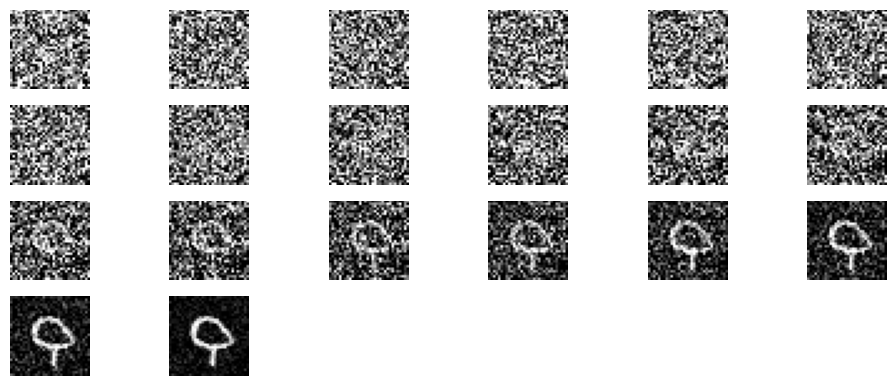

In [40]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (12, 6))

for i in range(gen_samples.shape[0]):
    plt.subplot(5, 6, i + 1)
    plt.imshow((gen_samples[i, 4 , :, :] *255).type(torch.uint8), cmap = 'gray')
    plt.axis('off')